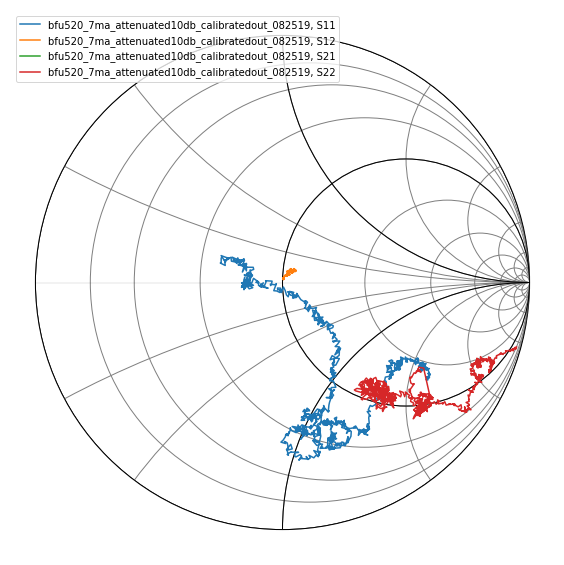

In [2]:
import numpy as np

import skrf
import skrf.media as media
from skrf.media import DistributedCircuit
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.1, 0.95, 1001)
tem = DistributedCircuit(f, z0=50)

bjt = net.Network('bfu520_7ma_attenuated10db_calibratedout_082519.s2p').interpolate(f)

bjt

bjt.plot_s_smith()

In [3]:
# well, on the bright side it stays mostly inside the unit circle
# let's calculate the matching values for 144 MHz and 915 MHz

# calculate the stability circles for the source and load impedances

idx_915mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)
idx_144mhz = skrf.util.find_nearest_index(bjt.f, 144.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rl_915mhz = rl[idx_915mhz][0, 0]
cl_915mhz = cl[idx_915mhz][0, 0]

rl_144mhz = rl[idx_144mhz][0, 0]
cl_144mhz = cl[idx_144mhz][0, 0]

rl_144mhz, cl_144mhz, rl_915mhz, cl_915mhz

(0.24538732275188085,
 (0.90996369931107579+0.54180299545778843j),
 1.2327504787552828,
 (1.3139029137857448+1.8217439279569125j))

0.962850018361 (0.64561388404+1.3232778444j) 15.1519702283 (13.7246198854+3.34314489994j)


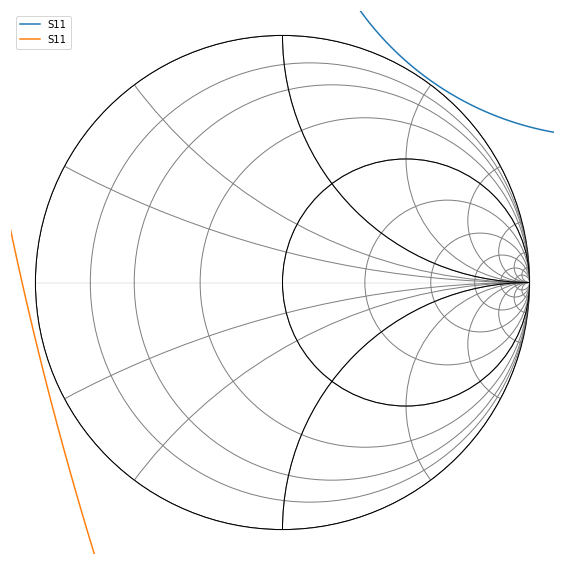

In [4]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()

rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

rs_144mhz = rs[idx_144mhz][0, 0]
cs_144mhz = cs[idx_144mhz][0, 0]
rs_915mhz = rs[idx_915mhz][0, 0]
cs_915mhz = cs[idx_915mhz][0, 0]

print(rs_144mhz, cs_144mhz, rs_915mhz, cs_915mhz)

cl_points = calc_circle(cl_915mhz, rl_915mhz)
cs_points = calc_circle(cs_915mhz, rs_915mhz)
plot_smith(cl_points)
plot_smith(cs_points)

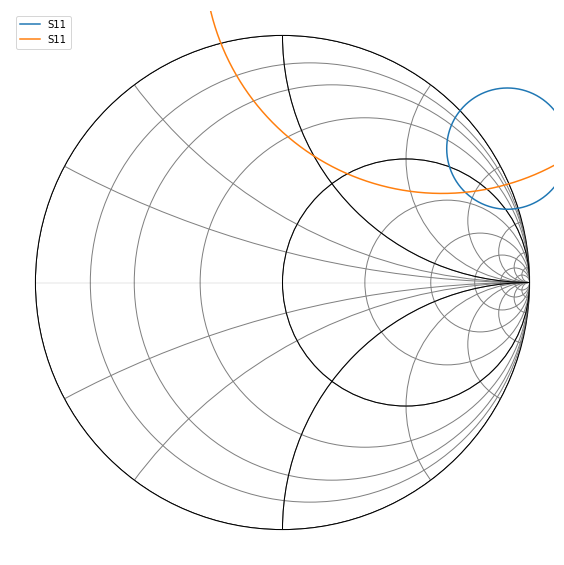

In [5]:
cl_points = calc_circle(cl_144mhz, rl_144mhz)
cs_points = calc_circle(cs_144mhz, rs_144mhz)
plot_smith(cl_points)
plot_smith(cs_points)

In [12]:
# so the amplifier's pretty stable at 915 MHz, and we need to avoid inductive loads at 144 MHz

# eh let's try a simultaneous conjugate match at 144 MHz after adding some shunt resistance, and see how stable that is
# it looks like a little series output resistance would stabilize 915 MHz, so let's add some and then do a simultaneous
# conjugate match there as well

def conjugate_match(ntwk, idx):
    # that doesn't look too bad, so let's move forward and try to conjugate match
    delta2 = ntwk.s11.s[idx, 0, 0]*ntwk.s22.s[idx, 0, 0] - ntwk.s12.s[idx, 0, 0]*ntwk.s21.s[idx, 0, 0]

    B1 = 1 + sqabs(ntwk.s11.s[idx, 0, 0]) - sqabs(ntwk.s22.s[idx, 0, 0]) - sqabs(delta2)
    B2 = 1 + sqabs(ntwk.s22.s[idx, 0, 0]) - sqabs(ntwk.s11.s[idx, 0, 0]) - sqabs(delta2)
    C1 = ntwk.s11.s[idx, 0, 0] - delta2*np.conj(ntwk.s22.s[idx, 0, 0])
    C2 = ntwk.s22.s[idx, 0, 0] - delta2*np.conj(ntwk.s11.s[idx, 0, 0])

    gamma_s = (B1 - np.sqrt(np.square(B1) - 4*sqabs(C1) + 0j))/(2*C1)
    gamma_l = (B2 - np.sqrt(np.square(B2) - 4*sqabs(C2) + 0j))/(2*C2)

    z_s = net.s2z(np.array([[[gamma_s]]]))[0,0,0]
    z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]

    return z_s, z_l

bjt_144 = bjt ** tem.shunt(tem.resistor(110.) ** tem.short())

zs_144mhz, zl_144mhz = conjugate_match(bjt_144, idx_144mhz)
zs_144mhz, zl_144mhz

((84.016417525460881+116.58199865471924j),
 (79.988423988583222+49.292756871047388j))

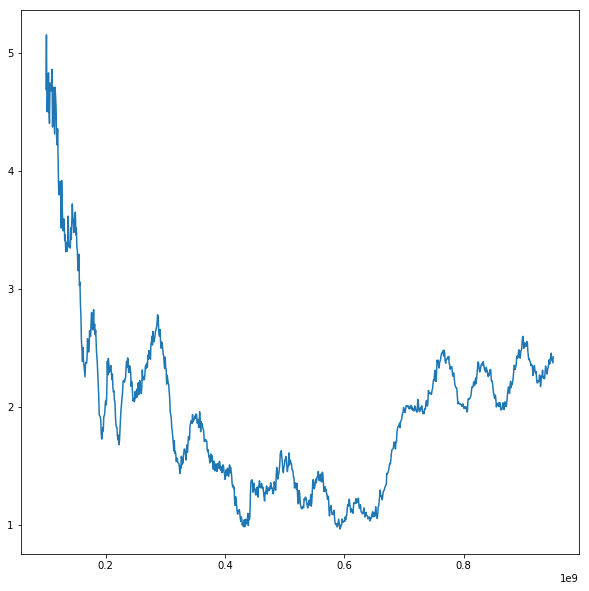

In [13]:
def K(ntwk):
    delta2 = ntwk.s11.s*ntwk.s22.s - ntwk.s12.s*ntwk.s21.s
    k = ((1 - sqabs(ntwk.s11.s) - sqabs(ntwk.s22.s) + sqabs(delta2))/(2*np.absolute(ntwk.s12.s*ntwk.s21.s)))[:,0,0]
    return k

plt.plot(bjt_144.f, K(bjt_144))

In [29]:
def calc_matching_network(z1, z2):
    flipped = ((abs(np.imag(z2)) < 1e-6 and np.real(z1) < np.real(z2)) or
            (abs(np.imag(z2)) > 1e-6 and np.real(z1) < np.real(1/(1/z2-1/(1.j*np.imag(z2))))))
    if flipped:
        z2, z1 = z1, z2
        
    # cancel out the imaginary parts of both input and output impedances    
    z1_par = 1e+10
    if abs(np.imag(z1)) > 1e-6:
        # parallel something to cancel out the imaginary part of
        # z1's impedance
        z1_par = 1/(-1j*np.imag(1/z1))
        z1 = 1/(1./z1 + 1/z1_par)
    z2_ser = 0.0
    if abs(np.imag(z2)) > 1e-6:
        z2_ser = -1j*np.imag(z2)
        z2 = z2 + z2_ser
        
    Q = np.sqrt((np.real(z1) - np.real(z2))/np.real(z2))
    x1 = -1.j * np.real(z1)/Q
    x2 = 1.j * np.real(z2)*Q
    
    x1_tot = 1/(1/z1_par + 1/x1)
    x2_tot = z2_ser + x2
    if flipped:
        return x2_tot, x1_tot
    else:
        return x1_tot, x2_tot
    
zs_144mhz_1, zs_144mhz_2 = calc_matching_network(50., np.conj(zs_144mhz))
zl_144mhz_1, zl_144mhz_2 = calc_matching_network(np.conj(zl_144mhz), 50.)

zs_144mhz_1, zs_144mhz_2, zl_144mhz_1, zl_144mhz_2

(98.94107678366402j,
 -415.7338067603979j,
 -228.72461381828086j,
 54.93861027793749j)

In [30]:
ls_144mhz = np.real(zs_144mhz_1/(2.j*np.pi*144e+6))
cs_144mhz = np.real(1/(2.j*np.pi*144e+6*zs_144mhz_2))

cl_144mhz = np.real(1/(2.j*np.pi*144e+6*zl_144mhz_1))
ll_144mhz = np.real(zl_144mhz_2/(2.j*np.pi*144e+6))

ls_144mhz, cs_144mhz, cl_144mhz, ll_144mhz

(1.0935389892329788e-07,
 2.6585344814100594e-12,
 4.8321981701474735e-12,
 6.072049578008999e-08)

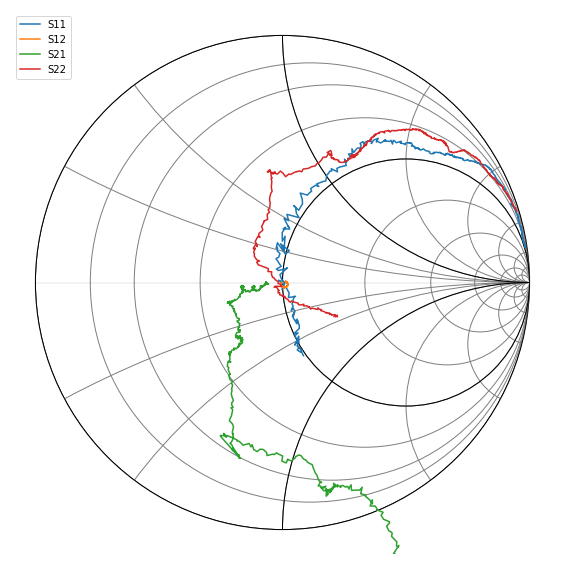

In [60]:
# a little bit of playing around lets me figure out which one's the shunt and which is in series
#input_network_144 = tem.inductor(ls_144mhz) ** tem.shunt_capacitor(cs_144mhz)
input_network_144 = tem.inductor(120.e-9) ** tem.shunt_capacitor(3e-12)
output_network_144 = tem.shunt_capacitor(4.7e-12) ** tem.inductor(ll_144mhz)

amplifier_144 = input_network_144 ** bjt ** tem.shunt(tem.resistor(120.) ** tem.short()) ** output_network_144

amplifier_144.plot_s_smith()

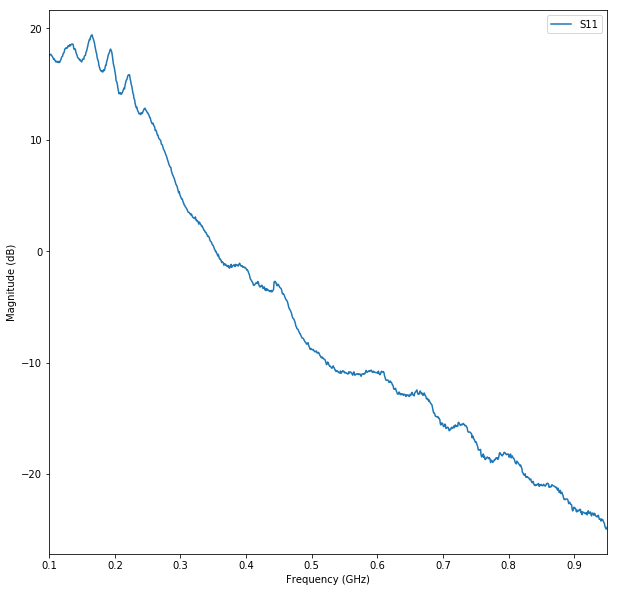

In [61]:
amplifier_144.s21.plot_s_db()

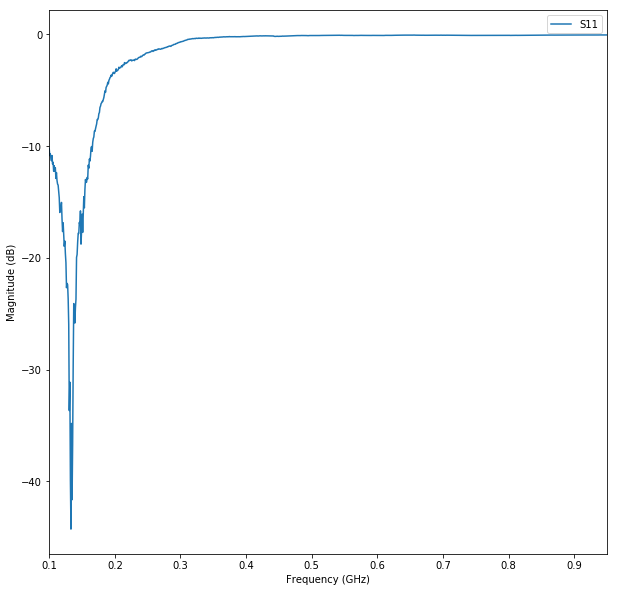

In [62]:
amplifier_144.s11.plot_s_db()

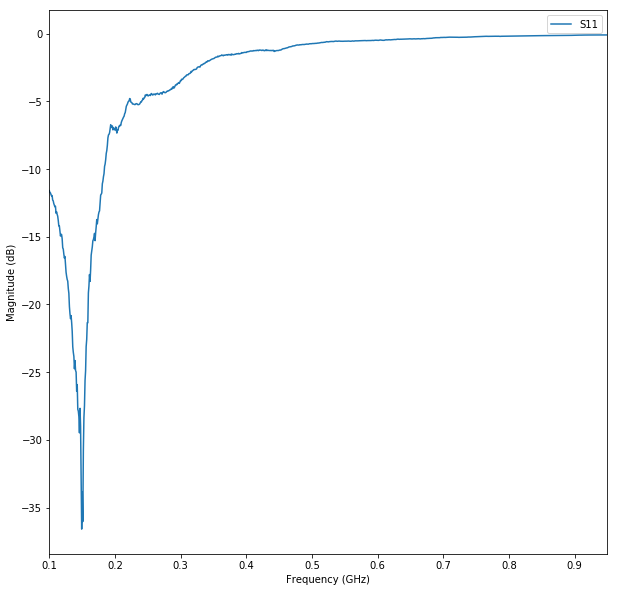

In [53]:
amplifier_144.s22.plot_s_db()

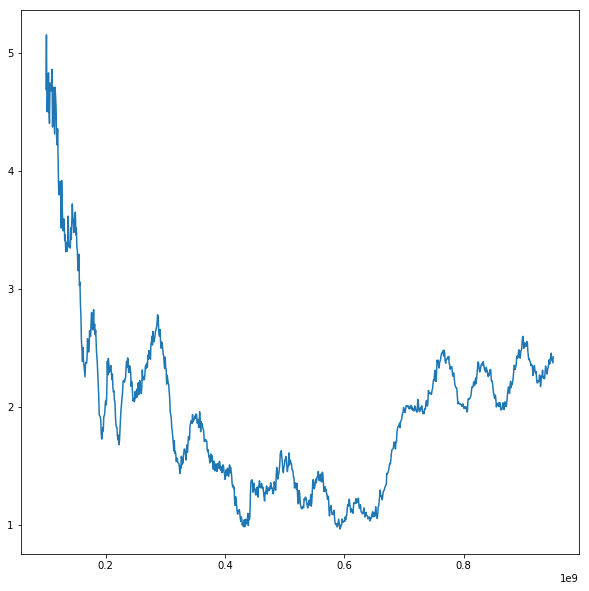

In [42]:
# that looks pretty good, I'm going to set it up and see how well it actually performs
# quick stability check (K>1 for stability)
plt.plot(amplifier_144.f, K(amplifier_144))